# Linear Regression and Friends

I want to talk about linear regression computationally. You need to understand linear regression every which way, up and down. WHY? 

* Can apply it very widely
* Often works pretty darn well
* Can build non-linear regression on top of linear regression
* Lots of idea of linear regression used everywhere
* Many different approaches
* Good theoretical analysis
* Great examples on what goes wrong that is useful elsewhere
* Common language: Almost every one knows it
* Simple: Occam's razor -- why use something more complex if this works so try first

There are so many reasons why it is the "go to thing" ... somebody running a deep learning model when linear regression works as well is probably a moron. 

## What is a regression problem?

We have data a variable which was observed to have values $x_1, x_2, \ldots , x_n$. When we measured $x_i$ we also measured $y_i$ and we have reason to think that there is a functional relationship $f(x)=y$. For example maybe $x$ is altitude and $y$ is air pressure.

Maybe $f$ is a **linear** function/relationship which means there is a scaling coefficient $m$ and an offset $b$ so that 

$$y = f(x) = mx + b$$. 

Perhaps this is a bit to optimistic. We know that even at seal level pressure can vary a bit so we include an error term ${\bf \varepsilon}(x)$ which we will think of as random noise, partly because we don't know how to model it (yet). So really with this model we are guessing that 

$$y = f(x) = mx + b + {\bf \varepsilon}(x)$$.

Here this error term is pretty small. Lets just simulate what this would look like.

In [26]:
# Import the usual suspects
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
# Make the figures look better
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (9, 5)
mpl.rcParams['figure.dpi'] = 100

In [27]:
num_points = 100
np.random.seed(42) # seed 42 answer to life universe and everything
xs = np.random.random((num_points,)) # 100 Random between 0 and 1
noise_level = 0.3 # controls how small the noise is
es = np.random.randn(num_points)*noise_level # this is the per-mesurement normal noise 
m = 2.71828 # model scale factor (remember we don't usually know this but we are simulating)
b = 3.14159 # some offset ... again we are not suppose to know this 
ys = m*xs + b + es# These are the observed y measurements 

Text(0.5,1,'Synthetic linear data')

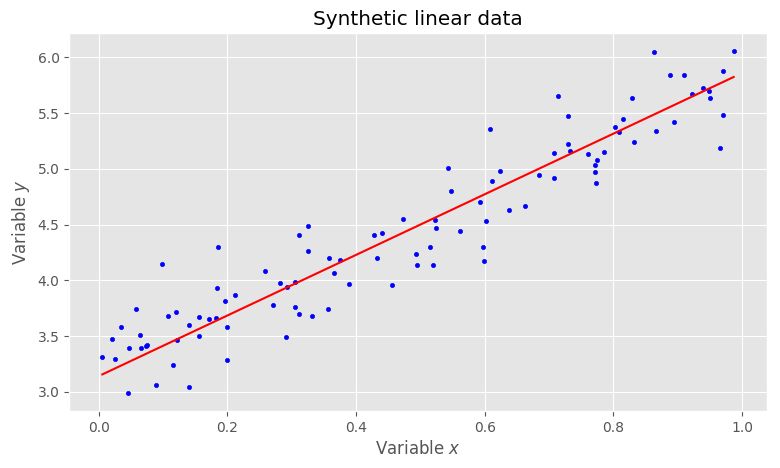

In [28]:
fig, ax = plt.subplots()
ax.scatter(xs,ys,color='b',marker='.')
ax.plot([xs.min(),xs.max()], [m*xs.min()+b,m*xs.max()+b],'r-') # in real life we don't know this line
ax.set_xlabel('Variable $x$')
ax.set_ylabel('Variable $y$')
ax.set_title('Synthetic linear data')

## Finding the slope

We learned linear algebra for a reason. We can put all our measurements in a matrices $\tilde{X}$, $\tilde{Y}$, and noise $E$ like this

$$ 
\tilde{X} = \left[ 
\begin{array}{c}
   x_1 \\
   x_2 \\
   \vdots \\
   x_n
\end{array}
\right],
Y = \left[ 
\begin{array}{c}
   y_1 \\
   y_2 \\
   \vdots \\
   y_n
\end{array}
\right],
E = \left[ 
\begin{array}{c}
   \varepsilon_1 \\
   \varepsilon_2 \\
   \vdots \\
   \varepsilon_n
\end{array}
\right],
$$

then we get the nice little formula 

$$ Y = (\tilde{X})m + b + E $$

where $m$ just multiplies each row and $b$ adds to each row. For various reasons we do a cute trick of replacing $\tilde{X}$ with a matrix with a column of $1$s and write $m$ and $b$ as a coefficient matrix $C$ like this:

$$ X = 
\left[ 
\begin{array}{ccc}
   x_1 & & 1\\
   x_2 & & 1\\
   &\vdots & \\
   x_n &  &1
\end{array}
\right],
C = \left[
\begin{array}{c}
   m \\
   b
\end{array}
\right]
$$

Then the equation nicely becomes

$$ Y = X C + E $$

Basically we want to try and solve (approximately) $Y=XC$ for $C$ to recover the slope $m$ and offset $b$. But *how*??
If only $X$ were a square matrix with an inverse!! .... then

$$ C = X^{-1} Y$$

but alas ... it is not square. **But wait!!!** There is a bit of a trick. What if we multiple both sides of the equation $XC=Y$ by $X^T$, the transpose of $X$. Well then $X^T X$ is a square $2 \times 2$ matrix. For typical (random) $X$ that will almost never be singular unless all the values of $x_i$ are the same!!! So if we think there is a solution to $XC=Y$ for $C$ then it must be true that

$$ X^T X C = X^T Y \implies C = (X^T X)^{-1} X^T Y $$

So ${\hat C} = (X^T X)^{-1} X^T Y$ implements an approximate solution when $E$ is not zero. It is the solution that minimizes the least square error. In other words if we defined the val $\hat{Y} = X\hat{C}$ and the error vector

$$E(C) = Y-{\hat Y} = Y - X{\hat C}$$ 

then the mean of square errors 

$$\mbox{SSE}(C) = ||E(C)||^2 = (\frac{1}{n}) E(C)^T E(C) = (\frac{1}{n}) \sum_i (\hat{y}_i - y)^2 $$

is the smallest it can be for all possible choices of $m$ and $b$. The smaller the noise the better the solution because the difference between the predicted $f(x)$ and the model is just the error $E$. Lets see this in code.

In [5]:
# Supplement X with ones for easier linear algebra
X = np.vstack([xs,np.ones(len(xs))]).T
X.shape

(100, 2)

In [6]:
# Need to go from shape (n,) [1-d array] to  
#  (n,1) [2-d array which happens to have one column]
Y = ys.reshape(len(ys),1)
Y.shape

(100, 1)

In [7]:
# This is actually where we compute the regression.
Chat = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))
print('Computed: m={}, b={},  actual m={}, b={}'.format(Chat[0][0],Chat[1][0], m, b))
# This is the projection of y onto the regressed line
yshat = np.dot(X,Chat)

Computed: m=2.580348031863082, b=3.2061188472640243,  actual m=2.71828, b=3.14159


Text(0.5,1,'Synthetic linear data')

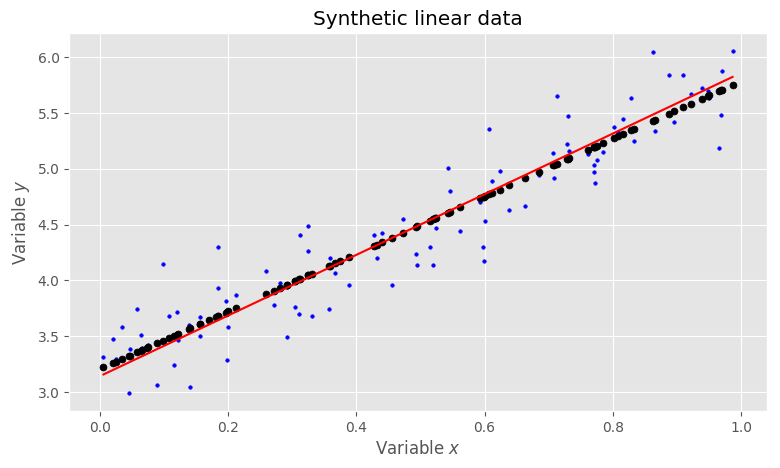

In [29]:
# Show the original y, the projected yhat, and the model line
fig, ax = plt.subplots()
# original data
ax.scatter(xs,ys,marker='.',color='b', s=25)
# Predicted y from the regression as black dots
ax.scatter(xs,yshat,marker='o',color='k', s=25)
# Line we only know because we made the data
ax.plot([xs.min(),xs.max()], [m*xs.min()+b,m*xs.max()+b],'r-') # in real life we don't know this line
ax.set_xlabel('Variable $x$')
ax.set_ylabel('Variable $y$')
ax.set_title('Synthetic linear data')

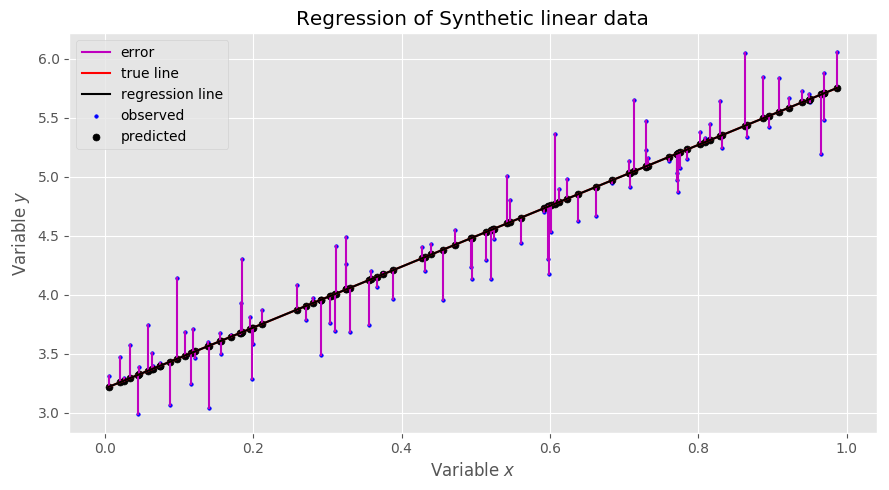

In [58]:
# Same as above but now we want to show the Errors and
# the line we get from regression
fig, ax = plt.subplots()
ax.scatter(xs,ys,marker='.',color='b', s=25, label='observed')
ax.scatter(xs,yshat,marker='o',color='k', s=25, label='predicted')
# Here we show the errors between the predicted (projected)
# values y and yhat
lines = ax.plot(np.vstack([xs,xs]), 
        np.vstack([np.squeeze(ys),np.squeeze(yshat)]),
        color='m')
# All the lines will look the same. We label 1
# if we had put label in the plot it would have created
# 100 line lables and blown up the legend (try it)
line = lines[0]
line.set_label('error')
ax.plot([xs.min(),xs.max()], 
        [m*xs.min()+b,m*xs.max()+b],'r-', 
        label='true line')
# This is the line estimated by linear regression
ax.plot([xs.min(),xs.max()], 
        [Chat[0][0]*xs.min()+Chat[1][0],Chat[0][0]*xs.max()+Chat[1][0]],
        'k-', label='regression line')
ax.set_xlabel('Variable $x$')
ax.set_ylabel('Variable $y$')
ax.set_title('Regression of Synthetic linear data')
ax.legend()
fig.tight_layout()

## Using numpy library linalg

We don't need to solve our linear regression ourselves. We have lots of libraries to do this. 
The numpy library has a basic but solid linear regression function. It lacks options but
it is pretty quick and simple to use. 

In [39]:
# rcond=None to stop the warning message
m_numpy, b_numpy = np.linalg.lstsq(X,Y,rcond=None)[0]
print('m_numpy={}, b_numpy={}'.format(m_numpy[0], b_numpy[0]))

m_numpy=2.58034803186309, b_numpy=3.2061188472640243


## Using the scipy library stats

Scipy has a stats library that has lost of useful statistics stuff.

In [11]:
from scipy import stats

The main difference from the numpy linear regression is that you get back
much more information about the error in terms of statistical measures
like the R value and the P value.

In [42]:
m_scipy, b_scipy, r_value, p_value, std_err = stats.linregress(xs,ys)
print('m_scipy={}, b_scipy={}'.format(m_scipy, b_scipy))

m_scipy=2.5803480318630903, b_scipy=3.2061188472640243


In [13]:
r_value # the error

0.9430440696601182

## Using scikit learn (machine learning library)

Here we see that first you create/fit a model. Then you can extract its coefficients. You could weight data if some data was less certain than other data.

In [14]:
from sklearn.linear_model import LinearRegression

When using sklearn you will often see this pattern: 

* initialize a model (no data yet)
* fit the model
* use the model

since you will be using sklearn for many things, including **non-linear** regression,
you will often just use the linear regression here.

In [15]:
# initialize the model
reg = LinearRegression()

In [ ]:
# fit the model
reg.fit(xs.reshape(len(xs),1),ys)

In [48]:
#Get the m and the b
print('sklearn_m={}, sklearn_b={}'.format(reg.coef_[0], reg.intercept_))

sklearn_m=2.5803480318630903, sklearn_b=3.2061188472640243


# Using Statsmodels

For linear regression you probably get the most analysis and flexibility in statmodels. It works similar to sklearn but more directly.

In [19]:
import statsmodels.api as sm

In [20]:
model = sm.OLS(ys,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     787.5
Date:                Fri, 19 Oct 2018   Prob (F-statistic):           1.22e-48
Time:                        13:09:52   Log-Likelihood:                -10.749
No. Observations:                 100   AIC:                             25.50
Df Residuals:                      98   BIC:                             30.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5803      0.092     28.063      0.0

## Multi-linear regression on the boston housing data set

We don't need to assume we have only two variables. We can assume we have several and still do linear regression. If we had $m$ and $b$ before lets now have a bunch of variables so lets call the offset $c_0$ and the others $c_1$, ... , $c_k$. The model we would be trying to figure out would have the form

$$ y = c_0 + c_1 x_1 + c_2 x_2 + \cdots c_l x_m $$

This gets a bit messy because now $x_i$ is not an observation but a variable! Thats because we have lots like "age" or "tax" ... not just one ... we have $m$. We need another index for observations. So now it looks like

$$ y_i = c_0 + c_1 x_{i,1} + c_2 x_{i,2} + \cdots c_l x_{i,k} $$

where $x_{i,j}$ is our data matrix, where $i$ indexes observations and $j$ indexes different variables. Note that it still looks like a dot product between the $C$ and the $X$ so we can **still** write $X=CY$ as an approximation, end everything else works exactly the same way. Lets use the sklearn version.

### Loading the libraries, and the data

In [21]:
from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()

print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [22]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Here we prepare the data as a pandas data frame. We get the data fields. We set the columns. We add the target as data as the last column and set the column name to be "PRICE".

In [23]:
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [24]:
%%html
<!-- Just evaluating putting raw JS in a cell -->
<h3>Running Muli-linear Regression </h3>
<p> Let's see how well we do when we try to predict price from all the other 
variables using multilinear regression. </p>

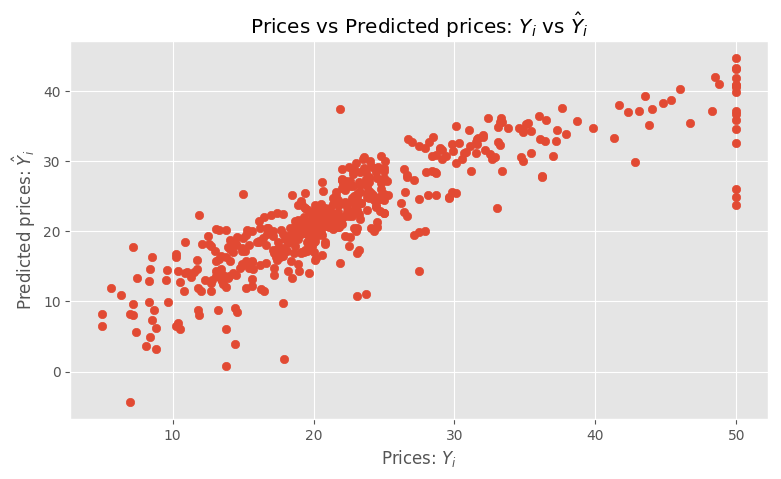

In [31]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(bos.iloc[:,:-1],bos['PRICE'])

Y_pred = lm.predict(bos.iloc[:,:-1])

plt.scatter(bos['PRICE'], Y_pred)
plt.xlabel('Prices: $Y_i$')
plt.ylabel('Predicted prices: $\hat{Y}_i$')
plt.title('Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$');

We would not consider this a great result. It does look like the predicted price and the actual price are related so the multi-linear regression isn't useless. The spread for each observed value is somewhat wide but there is a relationship. More concerning are the range of predicted prices that turn out to be 50. This needs further study